# Using GPT-4V

This notebook demonstrates how to use GPT-4V's image capabilities directly through the OpenAI API. 
We provide helper functions to simplify the creation of prompts and understanding which parameters are available while maintaining the complete flexibility that the API offers.

## Creating Prompts

Prompts for GPT-4V follow the familiar [chat completion](https://platform.openai.com/docs/guides/text-generation/chat-completions-api) format as the non-vision enabled models like `gpt-35-turbo` and `gpt-4-turbo`.

A chat completion prompt for one of those models looks as follows:

```python
messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Who won the world series in 2020?"},
    {"role": "assistant", "content": "The Los Angeles Dodgers won the World Series in 2020."},
    {"role": "user", "content": "Where was it played?"}
]
```

Vision enabled LLMs require a slightly different format. Images are available to the models in two ways: by passing a URL to an image or by passing the base64 encoded image directly in the request. Note that images can be passed in the `user`, `system` and `assistant` messages, however currently they cannot be in the *first* message.

An example of a prompt containing multiple text and image messages is as follows:

```python
import base64
from pathlib import Path

cat_image_path = Path("cat.jpg")
dog_image_path = Path("dog.jpg")

def encode_image(image_path: Path) -> str:
    with Path.open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")

messages = [
    {"role": "system", "content": "You are a helpful assistant."},
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "Describe the animal in the image in one word."},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encode_image(cat_image)}", "detail": "low"},
            },
        ],
    },
    {"role": "assistant", "content": "Cat"},
    {
        "role": "user",
        "content": [
            {"type": "text", "text": "What about this animal?"},
            {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{encode_image(dog_image)}", "detail": "high"},
            },
        ],
    },
]
```

Notice that we can have messages containing text as before. When we want to include images with a message, `content` becomes a list. That list can contain both text and image messages, in any order. We used the `encode_image` function to convert the image to base64 encoding. The optional `detail` parameter in the `image_url` message specifies the quality of the image. It can be either `low` or `high`. For more details on how images are processed and associated costs, refer to the [OpenAI API documentation](https://platform.openai.com/docs/guides/vision/low-or-high-fidelity-image-understanding).

Next let's use some helper functions to create another prompt that we will use to send a request to the OpenAI API.

[{'role': 'system', 'content': 'You are a helpful assistant.'},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Based on these infographics, can you summarize how Semantic Kernel works in exactly one sentence?'},
   {'type': 'image_url',
    'image_url': {'url': '',
     'detail': 'high'}},
   {'type': 'image_url',
    'image_url': {'url': '',
     'detail': 'low'}}]}]
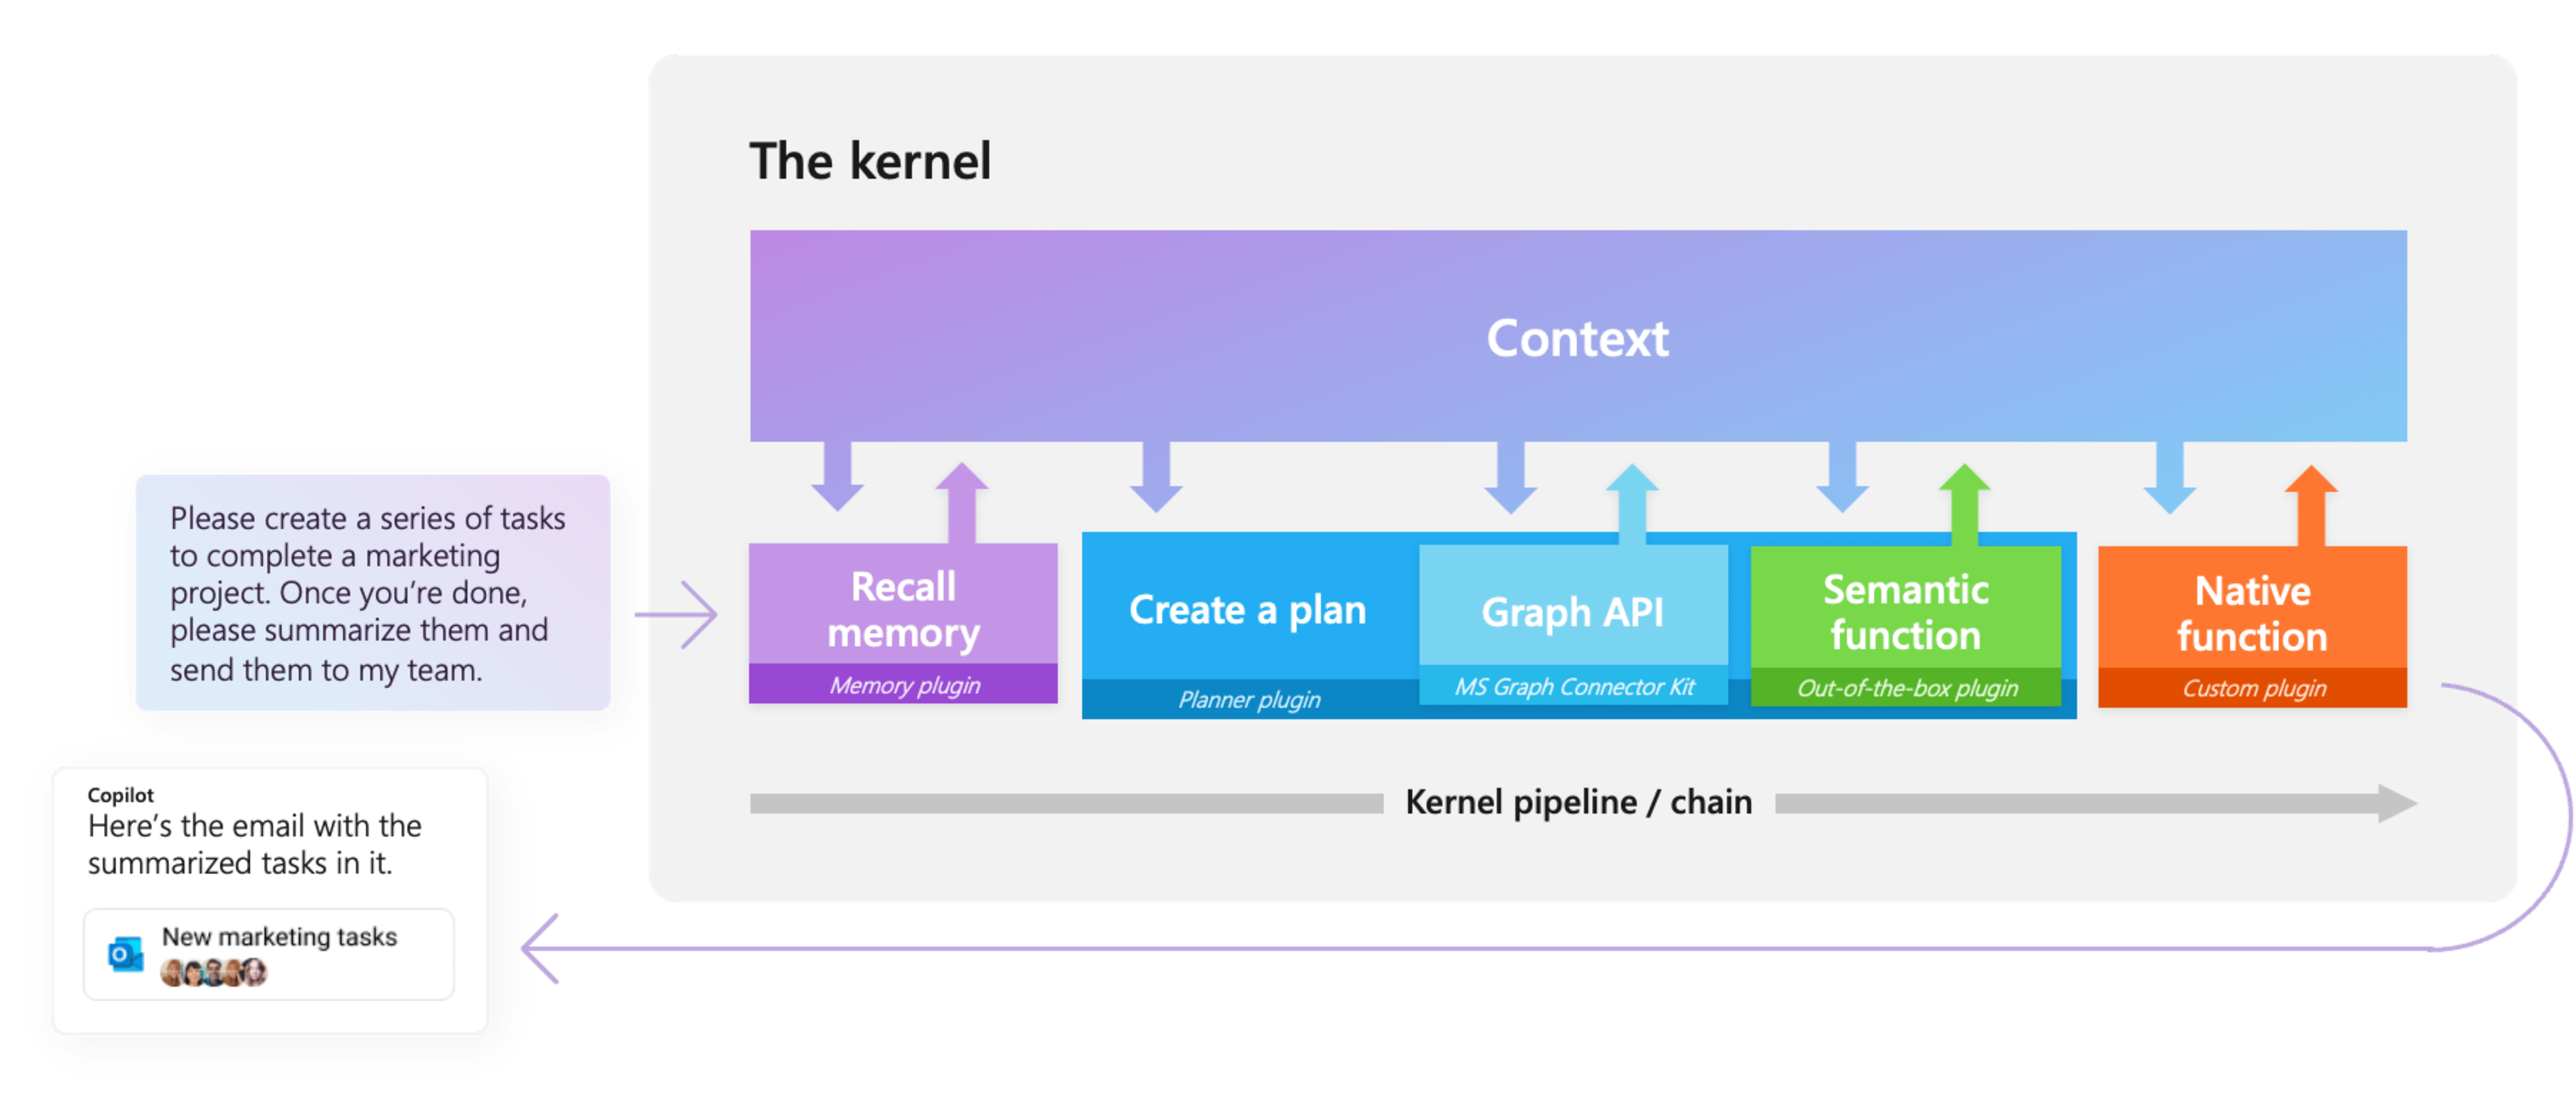
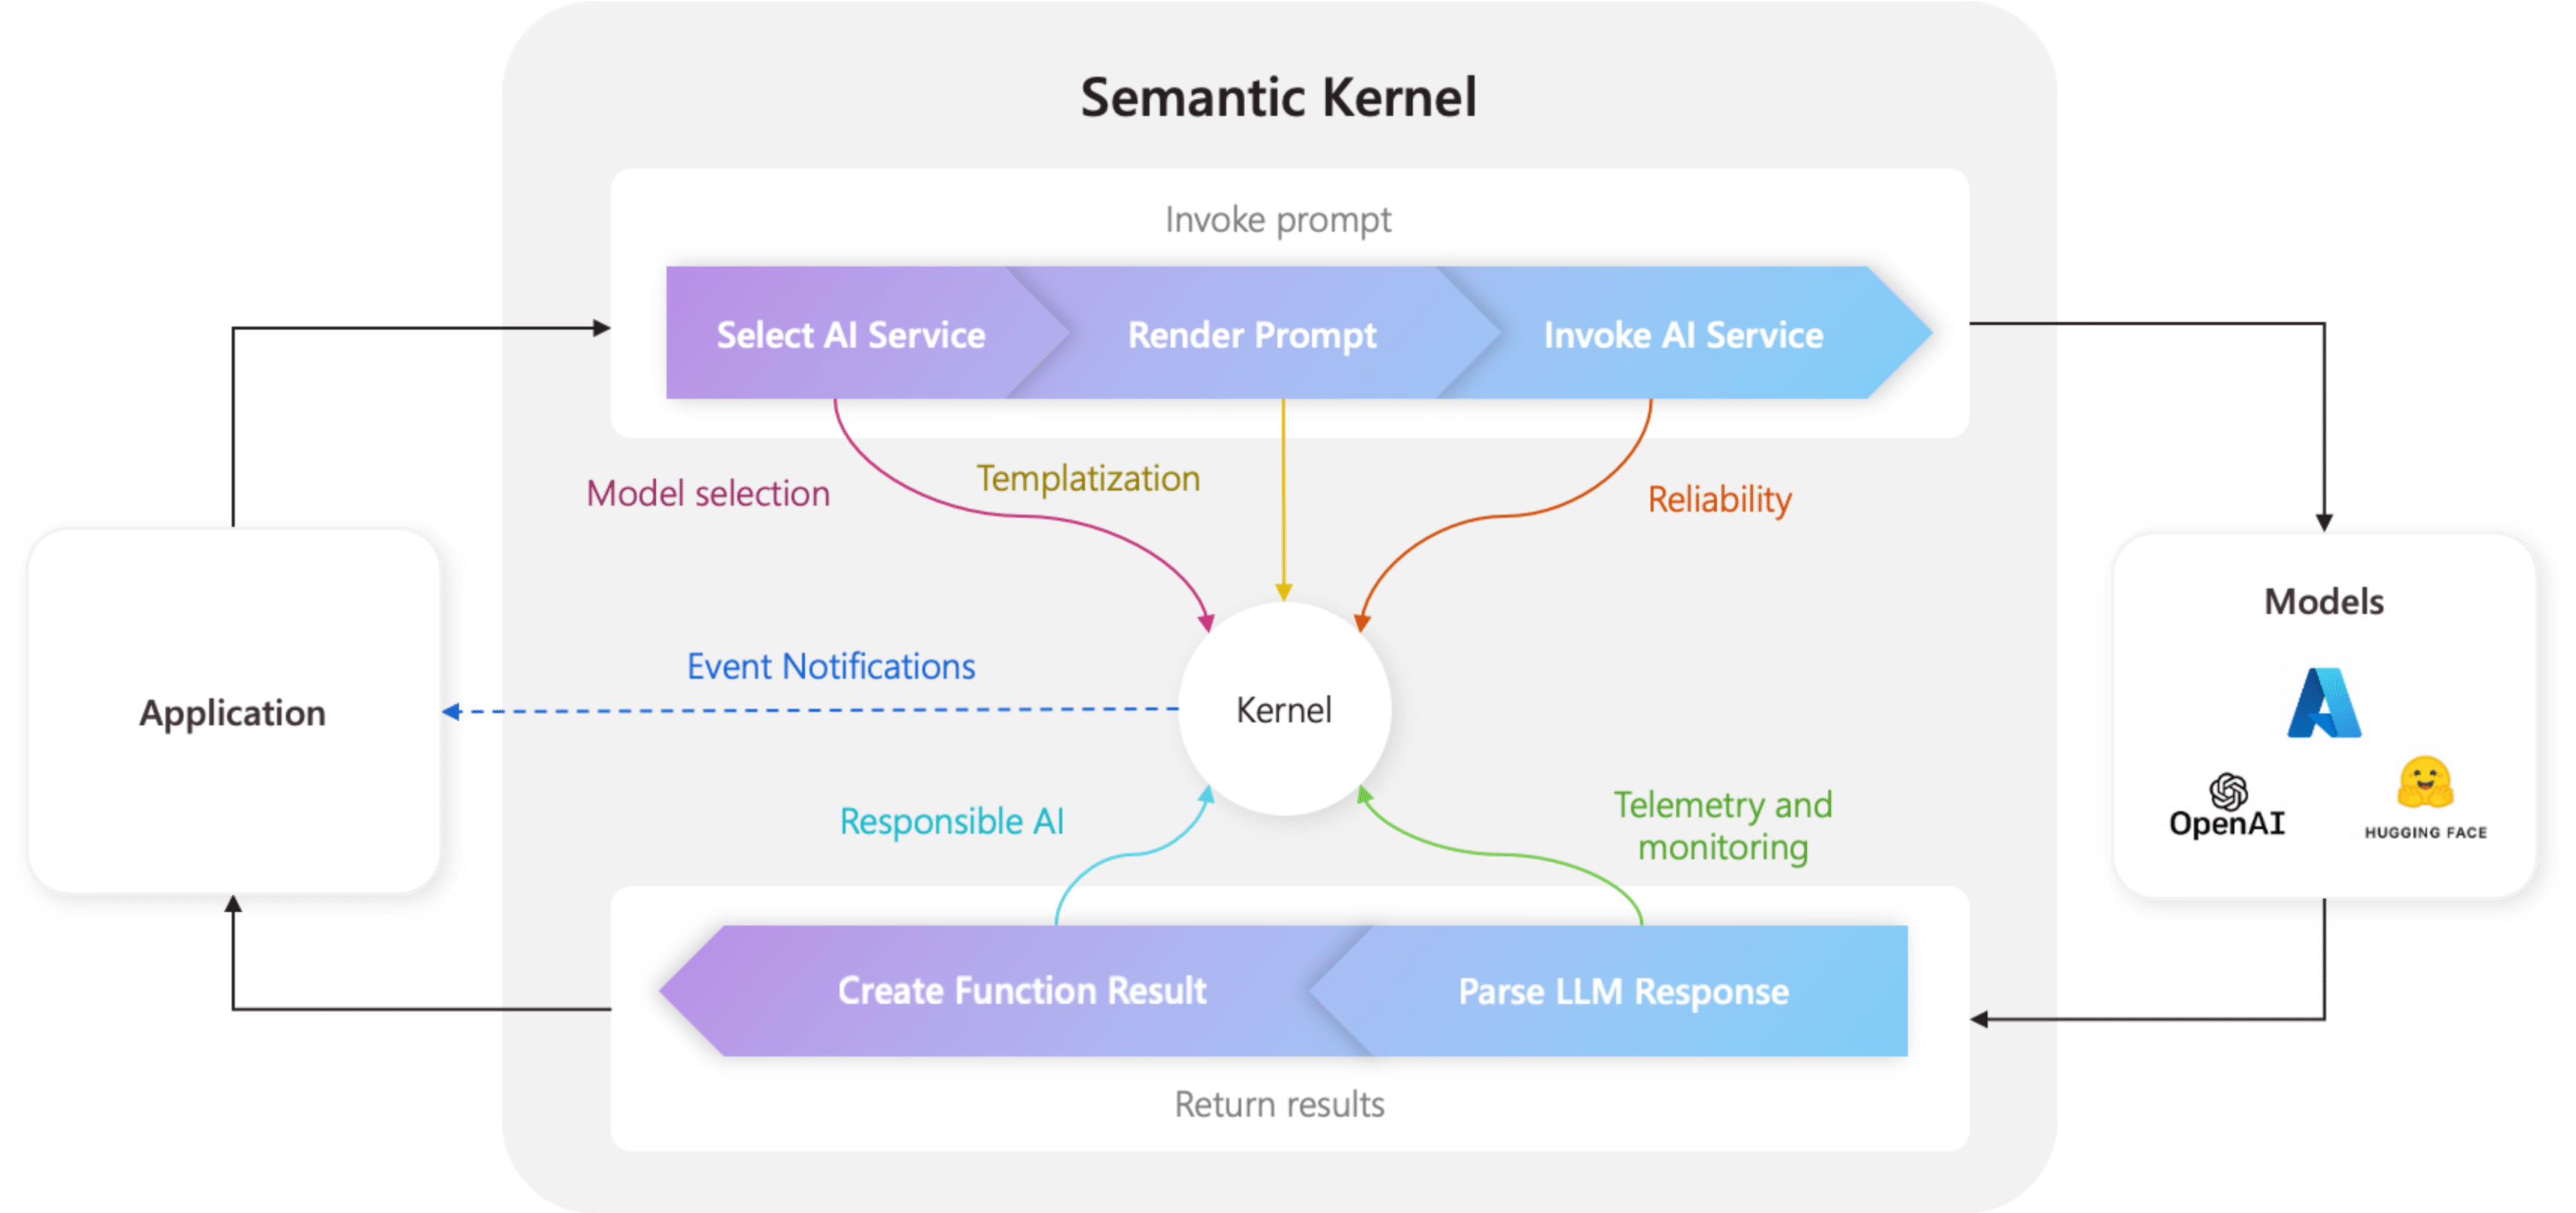

In [1]:
from pathlib import Path

from not_again_ai.llm.prompts import chat_prompt_vision

sk_infographic = Path.cwd().parent / "tests" / "llm" / "sample_images" / "SKInfographic.png"
sk_diagram = Path.cwd().parent / "tests" / "llm" / "sample_images" / "SKDiagram.png"

messages = [
    {"role": "system", "content": "You are a helpful {{ persona }}."},
    {
        "role": "user",
        "content": [
            "Based on these infographics, can you summarize how {{ library }} works in exactly one sentence?",
            {"image": sk_infographic, "detail": "high"},
            {"image": sk_diagram, "detail": "low"},
        ],
    },
]

prompt = chat_prompt_vision(messages, variables={"persona": "assistant", "library": "Semantic Kernel"})
prompt

Here are the two images that were encoded:

![../tests/llm/sample_images/SKInfographic.png](../tests/llm/sample_images/SKInfographic.png)
![../tests/llm/sample_images/SKDiagram.png](../tests/llm/sample_images/SKDiagram.png)

## Making an API Request

With prompt formatted, making the request is easy. 

One consideration is that currently the vision models do not support many parameters of the text only models such as: message.name, functions/tools, and response_format.


In [2]:
from openai import OpenAI

client = OpenAI()

response = client.chat.completions.create(
    model="gpt-4-1106-vision-preview",
    messages=prompt,
    max_tokens=200,
)
response

ChatCompletion(id='chatcmpl-9B3TrqCh63eGOU3UeCnvWIkPidGWa', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='Semantic Kernel operates by integrating various plugins and APIs that recall memory, create plans, and execute functions within a context-aware framework to seamlessly process and respond to tasks.', role='assistant', function_call=None, tool_calls=None))], created=1712422015, model='gpt-4-1106-vision-preview', object='chat.completion', system_fingerprint=None, usage=CompletionUsage(completion_tokens=32, prompt_tokens=1565, total_tokens=1597))

## Simplifying the response format

As we can see, the response from the API is quite verbose. We can simplify it by extracting only what is needed, depending on the parameters we provided in our request. 

Using our helper functions, let's send a request which tries to use all the available parameters. Notice that we use `n=2` to get two completions in one request. However, due to the seed they should always be equivalent. NOTE: We have noticed that the `seed` parameter is hit or miss and does not generate the same completions in all scenarios.

In [3]:
from not_again_ai.llm.chat_completion_vision import chat_completion_vision
from not_again_ai.llm.openai_client import openai_client

client = openai_client()

response = chat_completion_vision(
    messages=prompt, model="gpt-4-1106-vision-preview", client=client, max_tokens=200, temperature=0.5, seed=42, n=2
)
response

{'choices': [{'finish_reason': 'stop',
   'message': 'Semantic Kernel operates by selecting an AI service based on a rendered prompt, invoking the chosen service, and parsing the response to create a functional result that integrates with an application, while managing reliability and telemetry.'},
  {'finish_reason': 'stop',
   'message': 'Semantic Kernel processes input by selecting an AI service based on the context, rendering a prompt, invoking the service, and parsing the response to create actionable results within an application, while also handling event notifications, telemetry, and monitoring.'}],
 'completion_tokens': 85,
 'prompt_tokens': 1565}

In [4]:
# If we choose the default `n=1`, the response would look more like this:
response["choices"][0]

{'finish_reason': 'stop',
 'message': 'Semantic Kernel operates by selecting an AI service based on a rendered prompt, invoking the chosen service, and parsing the response to create a functional result that integrates with an application, while managing reliability and telemetry.'}